## 1. 데이터 전처리 (Text preprocessing)

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import string
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import squarify
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

- 파일을 불러온 후 title, company, description Column만 남기기
- 중복값을 제거

In [ ]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/indeed/Data_Scientist.csv')

In [ ]:
df1 = df.copy()
df1 = df1.drop(['Unnamed: 0','url'],axis=1)

In [ ]:
df2 = df1.drop_duplicates(['description'],keep='last')

In [ ]:
df2

,title,company,description
1,Data Scientist (Structured Products),EquiTrust Life Insurance Company,Job Details\nDescription\nEssential Duties and...
3,"Specialist, Data Science",Nationwide,As a team member in the Finance and Internal A...
4,Sr. Data Scientist (Remote),American Credit Acceptance,Overview:\nAmerican Credit Acceptance seeks a ...
5,Data Scientist Associate Sr (DADS06) BTB - LEG...,"JPMorgan Chase Bank, N.A.",J.P. Morgan's Corporate & Investment Bank (CIB...
6,Data Scientist,VyStar Credit Union,"At VyStar, we offer competitive pay, an excell..."
...,...,...,...
1295,Senior Data & Applied Scientist,Microsoft,Senior Data & Applied Scientist\nDo you have a...
1296,Senior Data Scientist,Takeda Pharmaceuticals,Job Description\nOBJECTIVES:\nEffectively work...
1297,Senior Data Scientist,eBay Inc.,eBay is a global commerce leader that allows y...
1298,Senior Data Scientist,Cox Automotive,"Cox Automotive, a subsidiary of Cox Enterprise..."


In [ ]:
df2.shape

(757, 3)

### 1) 토큰을 정제

- 문자를 소문자로 통일
- 분석에 관련 없는 정보 제거
- 이번 과제는 `spacy` 로부터 `"en_core_web_sm"` 을 로드하여 진행

- ** 대문자를 소문자로 변경하는 함수를 입력 **
- ** 정규 표현식을 사용하여 re 라이브러리에서 알파벳 소문자, 숫자만 받을 수 있는 코드 **

In [ ]:
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
regex = r"[^a-z0-9\n ]"
subst = ""

def tokenize(text):

    # 정규식 적용
    tokens = re.sub(regex, subst, text)
    # 소문자로 치환
    tokens = tokens.lower().split()
    
    return tokens

In [ ]:
df2['tokens'] = df2['description'].apply(tokenize)

In [ ]:
df2

,title,company,description,tokens
1,Data Scientist (Structured Products),EquiTrust Life Insurance Company,Job Details\nDescription\nEssential Duties and...,"[ob, etails, escription, ssential, uties, and,..."
3,"Specialist, Data Science",Nationwide,As a team member in the Finance and Internal A...,"[s, a, team, member, in, the, inance, and, nte..."
4,Sr. Data Scientist (Remote),American Credit Acceptance,Overview:\nAmerican Credit Acceptance seeks a ...,"[verview, merican, redit, cceptance, seeks, a,..."
5,Data Scientist Associate Sr (DADS06) BTB - LEG...,"JPMorgan Chase Bank, N.A.",J.P. Morgan's Corporate & Investment Bank (CIB...,"[organs, orporate, nvestment, ank, is, a, glob..."
6,Data Scientist,VyStar Credit Union,"At VyStar, we offer competitive pay, an excell...","[t, ytar, we, offer, competitive, pay, an, exc..."
...,...,...,...,...
1295,Senior Data & Applied Scientist,Microsoft,Senior Data & Applied Scientist\nDo you have a...,"[enior, ata, pplied, cientist, o, you, have, a..."
1296,Senior Data Scientist,Takeda Pharmaceuticals,Job Description\nOBJECTIVES:\nEffectively work...,"[ob, escription, ffectively, working, with, an..."
1297,Senior Data Scientist,eBay Inc.,eBay is a global commerce leader that allows y...,"[eay, is, a, global, commerce, leader, that, a..."
1298,Senior Data Scientist,Cox Automotive,"Cox Automotive, a subsidiary of Cox Enterprise...","[ox, utomotive, a, subsidiary, of, ox, nterpri..."


### 2) 정제한 토큰을 시각화

- Top 10 토큰을 프린트 하기
- 토큰의 수, 빈도 순위, 존재 문서 수, 비율 등 정보를 계산하기
- 토큰 순위에 따른 퍼센트 누적 분포 그래프를 시각화하기

- ** 추천 토큰 순위 10개 단어를 입력 **

In [ ]:
# Counter 객체는 리스트요소의 값과 요소의 갯수를 카운트 하여 저장
# 카운터 객체는 .update 메소드로 계속 업데이트 가능
word_counts = Counter()

# 토큰화된 각 리뷰 리스트를 카운터 객체에 업데이트 
df2['tokens'].apply(lambda x: word_counts.update(x))

# 가장 많이 존재하는 단어 순으로 10개
word_counts.most_common(10)

[('and', 21770),
 ('to', 12518),
 ('the', 9261),
 ('of', 8823),
 ('in', 6523),
 ('a', 6145),
 ('data', 5935),
 ('with', 5645),
 ('for', 3957),
 ('or', 3922)]

In [ ]:
def word_count(docs):
    
    # 단어 개수 빈도
    word_counts = Counter()

    # 단어 존재 문서 빈도, 해당 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 개수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # rank 열에 단어 빈도 순으로 순위를 저장합니다.
    # method='first': 같은 값의 경우 먼저나온 요소를 상위에 배치합니다.
    wc['rank'] = wc['count'].rank(method='first', ascending=False).astype(int)
    total = wc['count'].sum()

    # percent 열에는 말뭉치 내 단어의 비율을 계산합니다.
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # cul_percent 열에는 누적 비율을 저장합니다.
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # word_in_docs_percent 열에는 전체 문서 중 해당 단어가 존재하는 문서의 비율을 저장합니다.
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
wc = word_count(df2['tokens'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
146,and,755,21770,1,0.057371,0.057371,0.997358
25,to,754,12518,2,0.032989,0.090360,0.996037
157,the,744,9261,3,0.024406,0.114765,0.982827
54,of,745,8823,4,0.023251,0.138017,0.984148
38,in,748,6523,5,0.017190,0.155207,0.988111
109,a,738,6145,6,0.016194,0.171401,0.974901
92,data,721,5935,7,0.015641,0.187042,0.952444
194,with,742,5645,8,0.014876,0.201918,0.980185
325,for,726,3957,9,0.010428,0.212346,0.959049
112,or,710,3922,10,0.010336,0.222682,0.937913


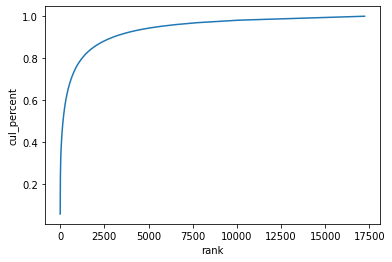

In [ ]:
sns.lineplot(x='rank', y='cul_percent', data=wc);

In [ ]:
wc[wc['rank'] <= 1000]['cul_percent'].max()

0.7712096895333119

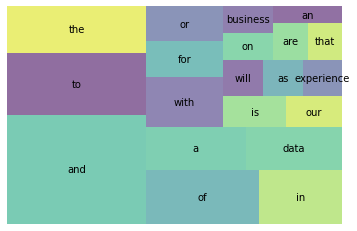

In [ ]:
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6)
plt.axis('off')
plt.show()

### 4) 확장된 불용어 사전을 사용해 토큰을 정제


- ** 기본 불용어 사전에 두 단어(`"data", "work"`)를 추가하는 코드를 사용하기 **
- ** 불용어를 제거하고 난 뒤 토큰 순위 10개의 단어를 입력하기 **

In [ ]:
STOP_WORDS = nlp.Defaults.stop_words.union(["data", "work"])
#data와 work추가하기 위해서 단어를 사전에 추가하기

tokens = []

for doc in df2['tokens']:
  
  doc_tokens = []
  
  for token in doc:
    
    if token not in STOP_WORDS:
      
      doc_tokens.append(token)
  
  tokens.append(doc_tokens)

df2['tokens'] = tokens
df2.tokens.head()

1    [ob, etails, escription, ssential, uties, espo...
3    [s, team, member, inance, nternal, udit, depar...
4    [verview, merican, redit, cceptance, seeks, hi...
5    [organs, orporate, nvestment, ank, global, lea...
6    [t, ytar, offer, competitive, pay, excellent, ...
Name: tokens, dtype: object

In [ ]:
word_counts = Counter()

# 업데이트
df2['tokens'].apply(lambda x: word_counts.update(x))

# Top 10 토큰
word_counts.most_common(10)

[('experience', 2071),
 ('business', 1886),
 ('team', 1529),
 ('ata', 1478),
 ('xperience', 1375),
 ('e', 1359),
 ('learning', 1337),
 ('analysis', 1273),
 ('skills', 1100),
 ('models', 1020)]

### 5) Lemmatization 사용 효과를 분석하기



- ** Lemmatization을 진행한 뒤 상위 10개 단어를 입력하기 **

In [ ]:

def get_lemmas(text):
    lemmas = []
    doc = nlp(text)

    for token in doc: 
        if re.sub(regex, subst, token.text.lower()) not in STOP_WORDS and (token.is_stop == False) and (token.is_punct == False) and (token.pos_ != 'PRON'):
          if (token.text != '\n') and (token.text != '\n\n'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [ ]:
df2['lemmas'] = df2['description'].apply(get_lemmas)

In [ ]:
wc = word_count(df2['lemmas'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
155,experience,691,2559,1,0.010416,0.010416,0.912814
345,team,630,2236,2,0.009102,0.019518,0.832232
520,business,530,2036,3,0.008287,0.027805,0.700132
137,analysis,536,1540,4,0.006269,0.034074,0.708058
119,model,517,1419,5,0.005776,0.039850,0.682959
139,product,439,1201,6,0.004889,0.044739,0.579921
88,skill,537,1189,7,0.004840,0.049578,0.709379
50,include,509,1176,8,0.004787,0.054365,0.672391
271,analytic,422,1146,9,0.004665,0.059030,0.557464
493,Experience,450,1099,10,0.004473,0.063503,0.594452


## 2. 유사한 문서 찾기

### 1) `TfidfVectorizer`를 이용해 각 문서들을 벡터화 한 후 KNN 모델을 만들고, <br/> 내가 원하는 `job description`을 질의해 가장 가까운 검색 결과들을 가져오고 분석

- ** 88번 index의 `job description`와 5개의 가장 유사한 `job description`이 있는 index를 입력하기 **
    - 답은 88번 인덱스를 포함
    - `max_features = 3000` 으로 설정

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

dtm_tfidf = tfidf.fit_transform(df2['description'])

dtm_tfidf = pd.DataFrame(dtm_tfidf.todense(), columns=tfidf.get_feature_names())
dtm_tfidf

,00,000,10,100,11,12,14,15,18,19,...,written,www,year,years,yelp,yes,york,yrs,zillow,zulily
0,0.0,0.000000,0.05272,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.023379,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.018485,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058510,0.000000,0.000000,0.017488,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.033337,0.00000,0.035082,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.060084,0.013012,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.047268,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.017653,0.0,0.000000,0.0,0.0,0.0,0.0
753,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028502,0.000000,0.000000,0.017038,0.0,0.000000,0.0,0.0,0.0,0.0
754,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026058,0.036732,0.000000,0.062308,0.0,0.000000,0.0,0.0,0.0,0.0
755,0.0,0.024906,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.029165,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
#dtm을 knn으로 학습
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree') 
nn.fit(dtm_tfidf)

NearestNeighbors(algorithm='kd_tree')

In [ ]:
#인덱스 88문서와 비슷한 문서 검색
nn.kneighbors([dtm_tfidf.iloc[88]])

(array([[0.        , 0.08253523, 0.1293321 , 1.29275998, 1.3027987 ]]),
 array([[ 88, 268, 267, 525, 509]]))

## 3. TF-IDF 이용한 텍스트 분류 진행하기

TF-IDF를 이용해 문장 혹은 문서를 벡터화한 경우, 이 벡터값을 이용해 문서 분류 태스크를 진행할 수 있으며,

현재 다루고 있는 데이터셋에는 label이 존재하지 않으므로, title 컬럼에 "Senior"가 있는지 없는지 여부를 통해 Senior 직무 여부를 분류하는 작업을 진행하기

### 1) title 컬럼에 "Senior" 문자열이 있으면 1, 없으면 0인 "Senior"라는 새로운 컬럼을 생성하기

새롭게 만든 Senior 컬럼에서 값이 1인 (Senior O) 데이터의 개수는?

In [ ]:
df2['senior'] = df2['title'].apply(lambda x: 1 if "Senior" in x else 0)

In [ ]:
df2['senior'].value_counts()

0    662
1     95
Name: senior, dtype: int64

sklearn의 `train_test_split`을 통해 train 데이터와 valid 데이터로 나눈 후, `sklearn`의 `DecisionTreeClassifier`를 이용해 분류를 진행 

단, x값은 위에서 학습한 dtm_tfidf를 그대로 이용하고, train_test_split과 DecisionTreeClassifier의 random_state을 42로 고정하고, test_size는 0.1로 설정

학습을 완료한 후, test 데이터에 대한 예측을 진행하고 label 1에 대한 precision과 recall 값을 적기

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dtm_tfidf,df2['senior'],test_size=0.1, random_state=42)

In [ ]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
pred = dtc.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        67
           1       0.21      0.33      0.26         9

    accuracy                           0.78        76
   macro avg       0.56      0.58      0.56        76
weighted avg       0.82      0.78      0.80        76

